Create and activate your environment, then run:

```bash
% cd $HOPPERSCAPES_ROOT
% python -m pip install -r requirements.txt
% python -m pip install -e .
```

and use the working environment to run the notebooks.

## Demo Inference Pipeline

The following notebook demonstrates how to apply the compact segmentation model to perform inference on images from the HopperScapes ome-zarr dataset. The model is designed to segment various features of _L. delicatula_ forewings, including wing outlines, pigmentation domains, and spots.

Notes:

- ``HopperNetLite_demo.pth`` is pretrained on a small downsampled dataset of manual segmentations. It is intended for demonstration only. The current checkpoint performs well on the wing outline, pigmentation domains, and spots segmentation tasks. We have moved on to a different architecture for the venation network segmentation task. See hopperscapes/segmentation/README.md for more details.

In [1]:
from hopperscapes.configs import SegmentationModelConfigs
from hopperscapes.segmentation.dataset import HopperZarrDataset
from hopperscapes.segmentation.infer import load_model, post_process_predictions

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Load sample dataset and pre-trained checkpoint

In [3]:
PATH_TO_ZARR_STORE = '../tests/test_data/zarr_demo.zarr/'
PATH_TO_MODEL_CHECKPOINT = '../checkpoints/HopperNetLite_demo.pth'
PATH_TO_CONFIGS = '../configs/unified_lite.yaml'

In [4]:
configs = SegmentationModelConfigs().from_yaml(PATH_TO_CONFIGS)
model = load_model(
    checkpoint_path=PATH_TO_MODEL_CHECKPOINT, 
    configs=configs, 
    device=device
)

In [5]:
model.heads

ModuleDict(
  (wing): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  (veins): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  (spots): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  (domains): Conv2d(16, 3, kernel_size=(1, 1), stride=(1, 1))
)

In [6]:
HEADS = ['wing', 'domains', 'spots']

In [7]:
dataset = HopperZarrDataset(
    PATH_TO_ZARR_STORE, 
    configs=SegmentationModelConfigs()
)

n_images = len(dataset)
print(f'found {n_images} samples in {PATH_TO_ZARR_STORE}.')

found 4 samples in ../tests/test_data/zarr_demo.zarr/.


### Run inference and plot the outputs

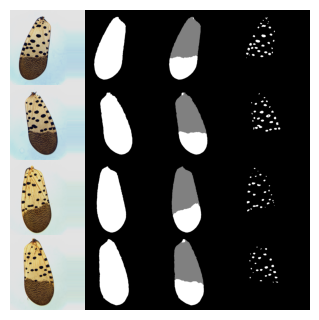

In [8]:
# prepare the figure
import matplotlib.pyplot as plt

nrows = n_images
ncols = len(HEADS) + 1  # +1 for the original image
aspect_ratio = nrows / ncols
figsize = (3, aspect_ratio * 3)
fig, ax = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=figsize
)

# run inference and plot the outputs
model.eval()
for i, sample in enumerate(dataset):
    image_tensor = sample['image']
    with torch.no_grad():
        predictions = model(
            image_tensor.unsqueeze(0).to(device)
            )
    # logits to masks
    predictions = post_process_predictions(predictions)

    # plot each head's prediction
    for j, head_name in enumerate(HEADS):
        ax[i, j+1].imshow(predictions[head_name], cmap='gray')

    ax[i, 0].imshow(image_tensor.permute(1, 2, 0).cpu().numpy(), cmap='gray')

for axi in ax.flat:
    axi.axis('off')

plt.tight_layout(pad=0)

We can now use these "first-pass" segmentations to standardize the dataset, or in the case of spots, use them as seeds to generate more accurate segmentations in subsequent passes.

Additional examples will demonstrate how to use the postprocessing pipeline accordingly.
